In [1]:
import matplotlib.pylab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from opt_einsum import contract,contract_path
from tqdm.auto import tqdm
import dacite
import torch
from torch.nn.functional import normalize
from scipy.optimize import curve_fit
import inspect
from functools import partial,wraps,reduce
def _toN(t):
    return t.detach().cpu().tolist()
def _toT(t):
    return torch.as_tensor(t)
def _normalize(t):
    return t/t.norm()
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
torch.cuda.set_device(0)

In [2]:
import importlib
import HOTRGZ2,TNModels,GILT,utils,ScalingDimensions,fix_gauge
importlib.reload(fix_gauge)
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(ScalingDimensions)
importlib.reload(GILT)
importlib.reload(utils)
from HOTRGZ2 import forward_tensor,forward_observable_tensor,forward_observable_tensors,trace_tensor,trace_two_tensors,get_lattice_size,get_dist_torus_2D
from HOTRGZ2 import HOTRG_layers,GILT_options,MCF_options
from TNModels import Ising2D,AKLT2D,AKLT2DStrange
from ScalingDimensions import show_effective_rank,show_diff,show_scaling_dimensions,show_asymmetry
from utils import show_matrix,show_tensor_ijkl,show_tensor_ikjl

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

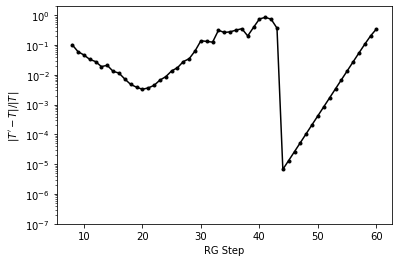

  0%|          | 0/61 [00:00<?, ?it/s]

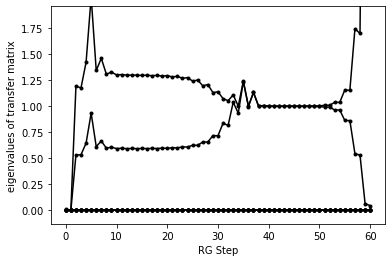

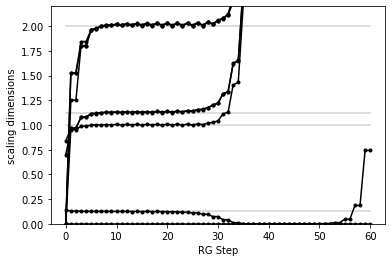

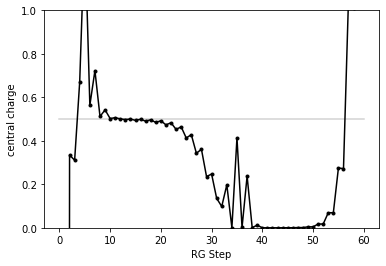

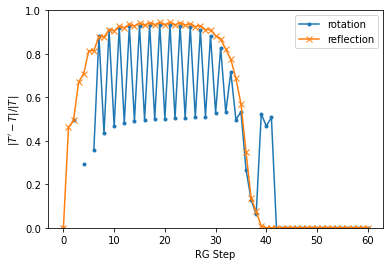

In [3]:
data=pd.DataFrame()
options={
    'nLayers':60,
    'max_dim':24,
    'gilt_enabled':True,
    'gilt_eps':8e-7,
    'gilt_nIter':1,
    #'gilt_record_S':True,
    'mcf_enabled':True,
    #'mcf_enabled_unitary':True,
    'mcf_eps':1e-6,
    'mcf_max_iter':50,
    #'hotrg_sanity_check':True,
    #'hotrg_sanity_check_tol':1e-7,
}

#params=AKLT2D.get_default_params()
#params['a2']=2.86522
#model=AKLT2D(params)
#T0,T0_op1,T0_op2=model.get_T0(),model.get_ST0(2),model.get_ST0(2)

#params=AKLT2DStrange.get_default_params()
#params['a2']=4
#model=AKLT2DStrange(params)
#T0,T0_op1,T0_op2=model.get_T0(),model.get_ST0(0)+model.get_ST0(1),model.get_ST0(0)-model.get_ST0(1)

params=Ising2D.get_default_params()
params['beta']+=0
model=Ising2D(params)
T0=model.get_T0()

reference_scaling_dimensions=[0.125,1,1.125,2]
reference_center_charge=.5

#dimR=model.get_dimR()
dimR=None

layers,Ts,logTotals=HOTRG_layers(T0,dimR=dimR,
                        max_dim=options['max_dim'],nLayers=options['nLayers'],
                        options=options,
                        return_tensors=True)

show_diff(Ts,stride=2)
#show_diff(fix_gauge.fix_gauges1(Ts,is_HOTRG=True),stride=2)
#show_effective_rank(Ts)
curve=show_scaling_dimensions(Ts,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=reference_scaling_dimensions,reference_center_charge=reference_center_charge)
show_asymmetry(Ts)

In [9]:
with tqdm() as pbar:
    for i in range(10):
        pbar.update(10)

0it [00:00, ?it/s]

In [23]:

def myeig1(M,k=10,arnoldi_num=25,arnoldi_interval=50):
    dim=M.shape[0]
    aa=[]
    with tqdm(total=arnoldi_num*(arnoldi_interval+1)) as pbar:
        for i in range(arnoldi_num):
            v=np.random.randn(dim);v=v/np.linalg.norm(v)
            for j in range(arnoldi_interval):
                vn=M*v
                for a in aa:
                    vn=vn-a*(a@vn)
                vn=vn/np.linalg.norm(vn)
                pbar.update(1)
            aa.append(vn)
        M1=np.zeros((arnoldi_num,arnoldi_num))
        for i in range(arnoldi_num):
            Ma=M*aa[i]
            for j in range(arnoldi_num):
                M1[j][i]=aa[j]@Ma
                pbar.update(1)
    aa=np.array(aa)
    print(M1.shape,aa.shape)
    s,v=np.linalg.eig(M1)
    return s,v@M1
            
    
    

# https://github.com/brucelyu/tensorRGflow/blob/main/analysisCodes/HOTRG.py
# https://pytorch.org/functorch/nightly/generated/functorch.jvp.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html



In [29]:
from HOTRGZ2 import forward_layer
from functorch import jvp,vjp
from math import prod
from scipy.sparse.linalg import eigs,eigsh,svds,LinearOperator

def get_linearized_HOTRG_autodiff(T0,layers):
    dimT=prod(T0.shape)
    x0=T0.reshape(-1)
    pbar=tqdm()
    print(f'dimension: {dimT}x{dimT}')
    def forward_layers(v):
        #print('foo')
        v=v.reshape(T0.shape)
        for layer in layers:
            v=forward_layer(v,v,layer)
        #print(v.shape)
        return v.reshape(dimT)
    def linearized_operator(x):
        #print('goo')
        x=torch.tensor(x)
        
        _,y=jvp(forward_layers,primals=(T0.reshape(-1),),tangents=(x,))
        
        y=y.detach().cpu().numpy()
        pbar.update(1)
        return y
    def linearized_operator_T(x):
        #print('goo')
        x=torch.tensor(x)
        
        _, vjpfunc=vjp(forward_layers,T0.reshape(-1))
        y=vjpfunc(x)[0]
        
        y=y.detach().cpu().numpy()
        pbar.update(1)
        return y
    return LinearOperator(shape=(dimT,dimT),matvec=linearized_operator,rmatvec=linearized_operator_T)

def get_linearized_HOTRG(T0,layers):
    dimT=prod(T0.shape)
    pbar=tqdm()
    def forward_layers(v):
        T,Y=T0,v.reshape(T0.shape)
        for layer in layers:
            T1=forward_layer(T,T,layer)
            Y1=forward_layer(T+Y,T,layer)-T1
            Y2=forward_layer(T,T+Y,layer)-T1
            T,Y=T1,Y1+Y2
        #print(T.norm(),T0.norm())
        Y*=T0.norm()/T.norm()
        return Y.reshape(-1)
    def operator(v):
        pbar.update(1)
        return forward_layers(torch.tensor(v)).detach().cpu().numpy()
    return LinearOperator(shape=(dimT,dimT),matvec=operator)



iLayer=16
norms=list(map(HOTRGZ2.gauge_invariant_norm,Ts))
T=Ts[iLayer]
T=ScalingDimensions.fix_normalize(T,is_HOTRG=True,norms=norms[:iLayer+1])

#sref=ScalingDimensions.get_transfer_matrix_spectrum_2D(T,loop_length=3)[1]


#M=get_op()

u,s,vh=svds(get_linearized_HOTRG_autodiff(T,layers[iLayer:iLayer+2]))
sr,ur=s,vh.T

#sr,ur=myeig1(get_linearized_HOTRG(T,layers[iLayer:iLayer+2]),arnoldi_num=25,arnoldi_interval=50)
        
#ncv=30
#maxiter=min(M.shape[0]*10,np.iinfo(np.int32).max)
#s,v=eigsh(M, k=5, which='LM',maxiter=maxiter,ncv=ncv)
#print(s)

print(options)
print('scaling dimensions from linearized TRG')
print(ScalingDimensions.get_scaling_dimensions(torch.tensor(sr),scaling=2))
print('central charge from linearized TRG')
print(ScalingDimensions.get_central_charge(torch.tensor(sr),scaling=2))

0it [00:00, ?it/s]

dimension: 331776x331776


ArpackError: ARPACK error -9999: Could not build an Arnoldi factorization. IPARAM(5) returns the size of the current Arnoldi factorization. The user is advised to check that enough workspace and array storage has been allocated.

In [22]:
sr

array([ 0.46670691,  0.13760623,  0.06380059, -0.2295186 , -0.45561751])

In [9]:

def get_linearized_cylinder(T0):
    dimT=prod(T0.shape)
    pbar=tqdm()
    def evolve(v):
        v=v.reshape(T0.shape)
        return contract('iIab,jJbc,kKcd,lLda,IJKL->ijkl',T0,T0,T0,T0,v).reshape(-1)
    def operator(v):
        pbar.update(1)
        return evolve(torch.tensor(v)).detach().cpu().numpy()
    return LinearOperator(shape=(dimT,dimT),matvec=operator)

sc,uc=myeig(get_linearized_cylinder(T),tol=1e-8,k=10,maxiter=20)
#sc,uc=myeig(get_linearized_cylinder(T),tol=1e-8,k=10,maxiter=200)

print('scaling dimensions from Transfer Matrix on a Cylinder')
print(ScalingDimensions.get_scaling_dimensions(torch.tensor(sc),scaling=np.exp(2*np.pi/4)))
print('central charge from Transfer Matrix on a Cylinder')
print(ScalingDimensions.get_central_charge(torch.tensor(sc),scaling=np.exp(2*np.pi/4)))

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

scaling dimensions from Transfer Matrix on a Cylinder
tensor([-0.0000, 0.1215, 1.0222, 1.1211, 1.1359, 2.0156, 2.0154, 2.0157, 2.0159,
        2.1481])
central charge from Transfer Matrix on a Cylinder
tensor(0.4624)


In [35]:
print(options)
print('scaling dimensions from linearized TRG')
print(ScalingDimensions.get_scaling_dimensions(torch.tensor(sr),scaling=2))
print('central charge from linearized TRG')
print(ScalingDimensions.get_central_charge(torch.tensor(sr),scaling=2))
print('scaling dimensions from Transfer Matrix on a Cylinder')
print(ScalingDimensions.get_scaling_dimensions(torch.tensor(sc),scaling=np.exp(2*np.pi/4)))
print('central charge from Transfer Matrix on a Cylinder')
print(ScalingDimensions.get_central_charge(torch.tensor(sc),scaling=np.exp(2*np.pi/4)))

{'nLayers': 60, 'max_dim': 24, 'gilt_enabled': True, 'gilt_eps': 8e-07, 'gilt_nIter': 1, 'mcf_enabled': True, 'mcf_eps': 1e-06, 'mcf_max_iter': 50}
scaling dimensions from linearized TRG
tensor([-0.0000, 0.1221, 1.0027, 1.1331, 1.1511, 2.0003, 2.0018, 2.0037, 2.0510,
        2.1209, 2.1984, 2.2027, 2.5067])
central charge from linearized TRG
tensor(23.9867)
scaling dimensions from Transfer Matrix on a Cylinder
tensor([-0.0000, 0.1215, 1.0222, 1.1211, 1.1359, 2.0156, 2.0154, 2.0157, 2.0159,
        2.1481])
central charge from Transfer Matrix on a Cylinder
tensor(0.4624)


In [36]:
#torch.save((params,options,Ts,layers),'linearized_tensors.pkl')
torch.save((iLayer,sr,ur,sc,uc),'linearized_eigen.pkl')

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

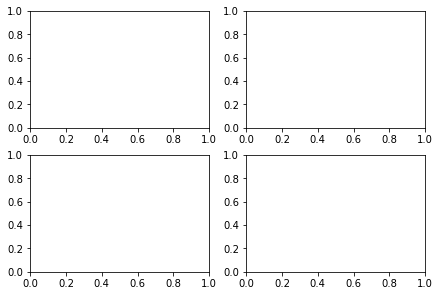

In [133]:
def show_perturbation_tensor(T_op,u,labels=None,title='', project_out=[],ax=None):
    u=torch.as_tensor(u)
    lT=_normalize(T_op.reshape(-1))
    #for v in project_out:
    #    v=torch.as_tensor(v)
    #    v=v.reshape(-1)/v.norm()
    #    lT=lT-(lT@v)*v
    b=lT@u
    for v in project_out:
        bv=_normalize(torch.as_tensor(v).reshape(-1)@u)
        b=b-(b@bv)*bv
    #b=b.abs()
    if ax is not None:
        plt.sca(ax)
    plt.title(title)
    plt.bar(range(len(b)),_toN(b),tick_label=labels)
    plt.xticks(rotation = 60)
    plt.axhline(0,color='black')
    if ax is None:
        plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

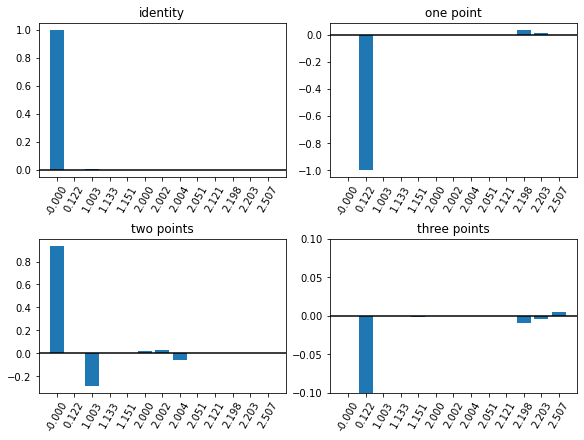

In [164]:
scd=ScalingDimensions.get_scaling_dimensions(torch.tensor(sr),scaling=2)
labels=[f'{d:.3f}' for d in scd]


    

T_id=Ts[20]
checkerboard=False


fig, axes = plt.subplots(2,2, constrained_layout=True,figsize=(8,6))

show_perturbation_tensor(T,ur, labels=labels, title='identity',ax=axes[0,0])

T0_op1,coords1=model.get_SZT0(),(511,511)
T,T_1pt1,logTotal=forward_observable_tensors(T0,[T0_op1],[coords1],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T0_op1,coords1=model.get_SZT0(),(511,512)
T,T_1pt2,logTotal=forward_observable_tensors(T0,[T0_op1],[coords1],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T0_op1,coords1=model.get_SZT0(),(512,511)
T,T_1pt3,logTotal=forward_observable_tensors(T0,[T0_op1],[coords1],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T0_op1,coords1=model.get_SZT0(),(512,512)
T,T_1pt4,logTotal=forward_observable_tensors(T0,[T0_op1],[coords1],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T_1pt=(T_1pt1+T_1pt2+T_1pt3+T_1pt4)/4
show_perturbation_tensor(T_1pt,ur, labels=labels, title='one point',ax=axes[0,1])


l,r=511-200,512+200

T0_op1,coords1=model.get_SZT0(),(l,511)
T0_op2,coords2=model.get_SZT0(),(r,511)
T,T_2pt,logTotal=forward_observable_tensors(T0,[T0_op1,T0_op2],[coords1,coords2],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
show_perturbation_tensor(T_2pt,ur, labels=labels, title='two points', project_out=[],ax=axes[1,0])


T0_op1,coords1=model.get_SZT0(),(511-100,511-173)
T0_op2,coords2=model.get_SZT0(),(511-100,511+173)
T0_op3,coords3=model.get_SZT0(),(511+200,511)
T,T_3pt,logTotal=forward_observable_tensors(T0,[T0_op1,T0_op2,T0_op3],[coords1,coords2,coords3],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
show_perturbation_tensor(T_3pt,ur, labels=labels, title='three points', project_out=[],ax=axes[1,1])
plt.ylim(-.1,.1)
plt.show()






  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

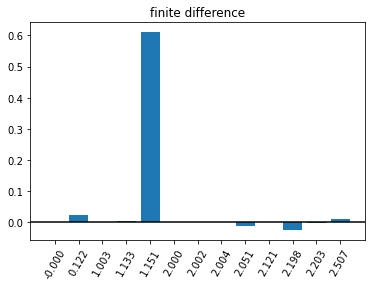

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

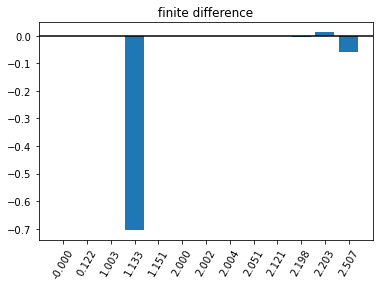

In [167]:
T0_op=model.get_SZT0()
coords1,coords2=(0,512),(1023,512)
T,T_op1,logTotal=forward_observable_tensors(T0,[T0_op],[coords1],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op2,logTotal=forward_observable_tensors(T0,[T0_op],[coords2],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)

T_fd=_normalize(T_op1)-_normalize(T_op2)
show_perturbation_tensor(T_fd,ur, labels=labels, title='finite difference',project_out=[])

T0_op=model.get_SZT0()
coords1,coords2=(512,0),(512,1023)
T,T_op1,logTotal=forward_observable_tensors(T0,[T0_op],[coords1],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op2,logTotal=forward_observable_tensors(T0,[T0_op],[coords2],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)

T_fd=_normalize(T_op1)-_normalize(T_op2)
show_perturbation_tensor(T_fd,ur, labels=labels, title='finite difference',project_out=[])

In [54]:
def normalize_perturbation_tensor(T,Tref):
    Tref=torch.as_tensor(Tref).reshape(-1)
    return T/(T.reshape(-1)@uref)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

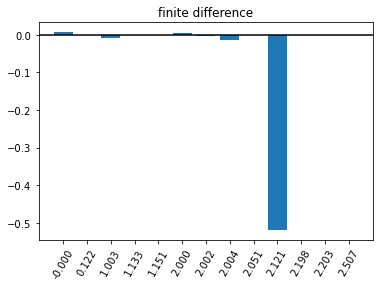

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

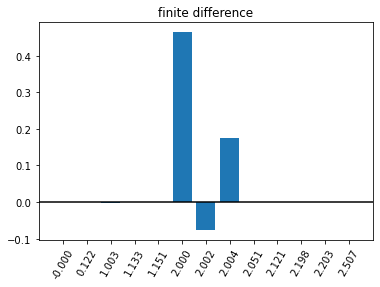

In [168]:
T0_op=model.get_SZT0()
coordss1,coordss2=[(0,511-100),(0,511+100)],[(1023,511-100),(1023,511+100)]
T,T_op1,logTotal=forward_observable_tensors(T0,[T0_op]*2,coordss1,\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op2,logTotal=forward_observable_tensors(T0,[T0_op]*2,coordss2,\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
#T_op1=normalize_perturbation_tensor(T_op1,ur[:,2])
#T_op2=normalize_perturbation_tensor(T_op2,ur[:,2])
T_fd=T_op1-T_op2
show_perturbation_tensor(T_fd,ur, labels=labels, title='finite difference',project_out=[])


T0_op=model.get_SZT0()
coordss1,coordss2=[(511-100,0),(511+100,0)],[(511-100,1023),(511+100,1023)]
T,T_op1,logTotal=forward_observable_tensors(T0,[T0_op]*2,coordss1,\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op2,logTotal=forward_observable_tensors(T0,[T0_op]*2,coordss2,\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
#T_op1=normalize_perturbation_tensor(T_op1,ur[:,2])
#T_op2=normalize_perturbation_tensor(T_op2,ur[:,2])
T_fd=T_op1-T_op2
show_perturbation_tensor(T_fd,ur, labels=labels, title='finite difference',project_out=[])

it looks pretty ads/cft-ish. if I put a positive charge on a point and a negative charge on another point, except for anticipated $\partial \phi$, the total contribution is not zero on $\phi$, depending on which charge is closer to the boundary

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

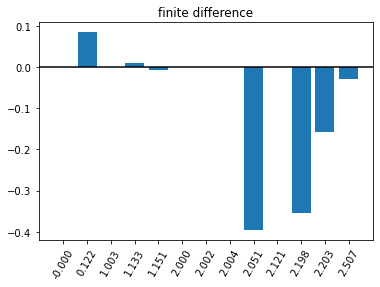

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

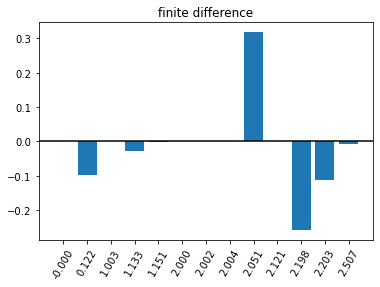

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

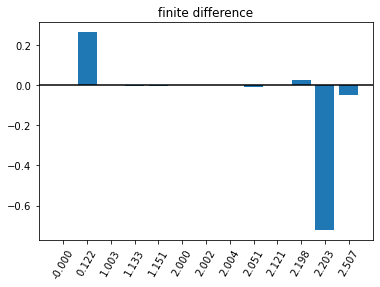

In [169]:
T0_op1,coords1=model.get_SZT0(),(0,511)
T0_op2,coords2=model.get_SZT0(),(511,511)
T0_op3,coords3=model.get_SZT0(),(1023,511)
T,T_op1,logTotal=forward_observable_tensors(T0,[T0_op1],[coords1],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op2,logTotal=forward_observable_tensors(T0,[T0_op2],[coords2],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op3,logTotal=forward_observable_tensors(T0,[T0_op3],[coords3],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)

T_fd=T_op1-2*T_op2+T_op3
show_perturbation_tensor(T_fd,ur, labels=labels, title='finite difference',project_out=[])

T0_op1,coords1=model.get_SZT0(),(511,0)
T0_op2,coords2=model.get_SZT0(),(511,511)
T0_op3,coords3=model.get_SZT0(),(511,1023)
T,T_op1,logTotal=forward_observable_tensors(T0,[T0_op1],[coords1],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op2,logTotal=forward_observable_tensors(T0,[T0_op2],[coords2],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op3,logTotal=forward_observable_tensors(T0,[T0_op3],[coords3],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)

T_fd=T_op1-2*T_op2+T_op3
show_perturbation_tensor(T_fd,ur, labels=labels, title='finite difference',project_out=[])

T0_op1,coords1=model.get_SZT0(),(511,0)
T0_op2,coords2=model.get_SZT0(),(511,511)
T0_op3,coords3=model.get_SZT0(),(511,1023)
T,T_op1,logTotal=forward_observable_tensors(T0,[T0_op1],[coords1],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op2,logTotal=forward_observable_tensors(T0,[T0_op2],[coords2],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)
T,T_op3,logTotal=forward_observable_tensors(T0,[T0_op3],[coords3],\
                            layers=layers[:20],checkerboard=checkerboard,\
                            cached_Ts=Ts)

T_fd=T_op1-2*T_op2+T_op3
show_perturbation_tensor(T_fd,ur, labels=labels, title='finite difference',project_out=[])

In [36]:
from fix_gauge import minimal_canonical_form

In [37]:
minimal_canonical_form(T)

In [41]:
1+11

12

In [66]:



def scan_line(length,stride,step,y):
    T0_op=model.get_SZT0()
    T_op_old=None
    data=pd.DataFrame()
    u=torch.as_tensor(ur)

    for i in tqdm(range(0,length-step,stride)):
        T,T_op,logTotal=forward_observable_tensors(T0,[T0_op],[(i,y)],\
                                layers=layers[:20],checkerboard=checkerboard,\
                                cached_Ts=Ts)
        #T_op=minimal_canonical_form(T_op)[0]
        #T,T_op1,logTotal=forward_observable_tensors(T0,[T0_op],[(i+step,y)],\
        #                        layers=layers[:20],checkerboard=checkerboard,\
        #                        cached_Ts=Ts)
        #T_op1=minimal_canonical_form(T_op1)
        T_op_norm=_toN(T_op.norm())
        T_op_dot=_toN(T_op.reshape(-1)@u)
        T_op_normalized_dot=_toN(_normalize(T_op).reshape(-1)@u)
        #T_op_diff=_toN((T_op1-T_op).norm()/step*length)
        #T_op_normalized_diff=_toN((_normalize(T_op1)-_normalize(T_op)).norm()/step*length)
        #T_op_dot_diff=_toN((T_op1-T_op).reshape(-1)@u/step*length)
        #T_op_normalized_dot_diff=_toN((_normalize(T_op1)-_normalize(T_op)).reshape(-1)@u/step*length)
        newRow={**params,
                **options,
                'x':i,'y':y,
                'T_op_norm':T_op_norm,
                'T_op_dot':T_op_dot,
                'T_op_normalized_dot':T_op_normalized_dot,
                #'T_op_diff':T_op_diff,
                #'T_op_normalized_diff':T_op_normalized_diff,
                #'T_op_dot_diff':T_op_dot_diff,
                #'T_op_normalized_dot_diff':T_op_normalized_dot_diff,
               }
        data=data.append(newRow,ignore_index=True)
        T_op_old=T_op
    return data

In [67]:
data=scan_line(length=1024,stride=8,step=8,y=512)

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

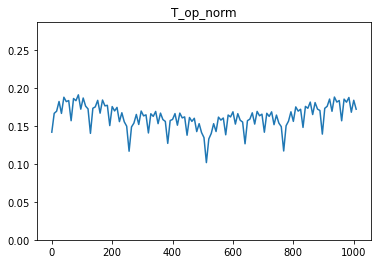

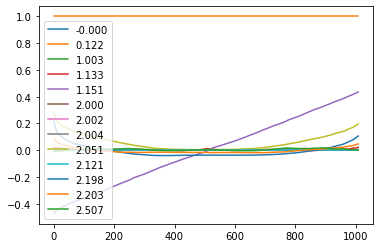

In [68]:
tdu=np.array(data['T_op_dot'].to_list())
tn=data['T_op_norm']


plt.plot(data['x'],tn)
plt.ylim([0,tn.max()*1.5])
plt.title('T_op_norm')
plt.show()

for i in range(ur.shape[1]):
    plt.plot(data['x'],tdu[:,i]/tdu[:,1],label=labels[i])
    #plt.ylim([-1.1,1.1])
    #plt.title(f'T_op_dot u{i}')
    #plt.show()
plt.legend()
plt.show()

In [136]:
import itertools as itt
importlib.reload(HOTRGZ2)
from HOTRGZ2 import get_isometry_from_layer



def contract_isometries_2D(layers):
    bond_dim=layers[0].tensor_shape[0]
    mapping={(i,j):torch.eye(bond_dim) for i,j in itt.combinations(range(4),2)}
    mappings={0:mapping.copy()}
    for iLayer in range(2,len(layers)+1,2):
        w0=layers[iLayer-1].get_isometry(2)
        w1=layers[iLayer-1].get_isometry(3)
        w2=layers[iLayer-2].get_isometry(2)
        w3=layers[iLayer-2].get_isometry(3)
        ws=[w0,w1,w2,w3]
        nMapping={}
        for (i,j),mij in mapping.items():
            nMapping[(i,j)]=contract('aij,bIJ,iI,jJ->ab',ws[i],ws[j].conj(),mij,mij)
        mapping=nMapping
        mappings[iLayer]=mapping
    return mappings
                
mappings=contract_isometries_2D(layers)
#for iLayer,mapping in mappings.items():
#    for (i,j),mij in mapping.items():
#        show_matrix(mij,max_dim=6)
#        plt.show()

ImportError: cannot import name 'get_isometry_from_layer' from 'HOTRGZ2' (/home/wenhan/jupyter/SRG/HOTRGZ2.py)

In [54]:
def cylinder_to_square(Tc,mapping):
    return contract('ijkl,jJ,kK,lL',Tc,mapping[(0,1)],mapping[(0,2)],mapping[(0,3)])

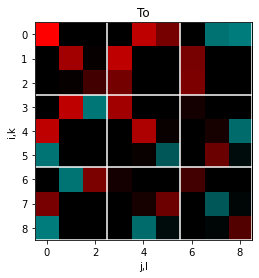

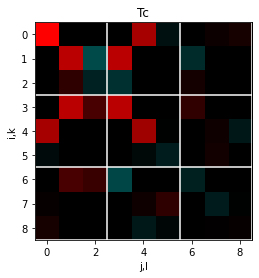

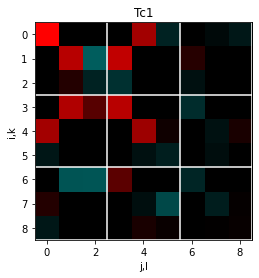

In [60]:
To=Ts[iLayer]
Tr=torch.tensor(ur[:,0]).reshape(T.shape)
Tc=torch.tensor(uc[:,0]).reshape(T.shape)
Tc=cylinder_to_square(Tc,mappings[iLayer])


def cleanup(T,Tref):
    T,_=fix_gauge.minimal_canonical_form(T,eps=0,max_iter=200)
    if(T[0,0,0,0]<0):T=-T
    #T,_=fix_unitary(T,Tref)
    T,dd=fix_gauge.fix_phase(T,Tref)
    T/=T.norm()
    return T

To=cleanup(To,Tref=Ts[iLayer])
Tr=cleanup(Tr,Tref=Ts[iLayer])
Tc=cleanup(Tc,Tref=Ts[iLayer])

def process(T):
    T=T/T.max()
    T=T.sign()*T.abs()**.5
    return T
show_tensor_ikjl(process(To.permute(2,3,0,1)),max_dim=3);plt.title('To');plt.show()
#show_tensor_ikjl(process(Tr),max_dim=3);plt.title('Tr');plt.show()
show_tensor_ikjl(process(Tc),max_dim=3);plt.title('Tc');plt.show()
show_tensor_ikjl(process(Tc1),max_dim=3);plt.title('Tc1');plt.show()

In [ ]:
To=Ts[]

In [574]:
from fix_gauge import contract_all_legs_but_one,apply_matrix_to_leg
from safe_svd import svd

def fix_unitary(T,Tref):
    hh=[]
    for k in range(len(T.shape)//2):
        MM=contract_all_legs_but_one(T,T,2*k)
        MMr=contract_all_legs_but_one(Tref,Tref,2*k)
        u,s,vh=svd(MM)
        ur,sr,vrh=svd(MMr)
        #show_matrix(MM);plt.show()
        #show_matrix(MMr);plt.show()
        #show_matrix(u);plt.show()
        #show_matrix(ur);plt.show()
        h=ur@u.T.conj()
        T=apply_matrix_to_leg(T,h,2*k)
        T=apply_matrix_to_leg(T,h.conj(),2*k+1)
        hh.extend([h,h.conj()])
    return T,hh

Tr-To tensor(0.0441)
Tc-Tr tensor(0.6715)
Tc-To tensor(0.6609)


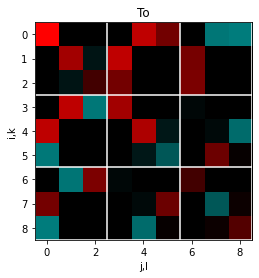

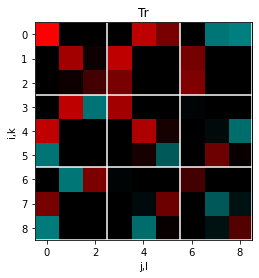

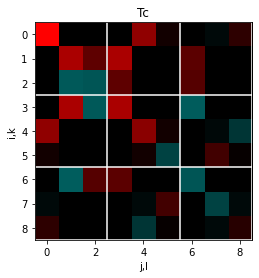

In [577]:

def cleanup(T,Tref):
    T,_=fix_gauge.minimal_canonical_form(T,eps=0,max_iter=200)
    if(T[0,0,0,0]<0):T=-T
    T,_=fix_unitary(T,Tref)
    T,dd=fix_gauge.fix_phase(T,Tref)
    T/=T.norm()
    return T

To=cleanup(Ts[iLayer],Tref=Ts[iLayer])
Tr=cleanup(torch.tensor(ur[:,0]).reshape(T.shape),Tref=Ts[iLayer])
Tc=cleanup(torch.tensor(uc[:,0]).reshape(T.shape),Tref=Ts[iLayer])
    
print('Tr-To',(Tr-To).norm())
print('Tc-Tr',(Tc-Tr).norm())
print('Tc-To',(Tc-To).norm())

def process(T):
    T=T/T.max()
    T=T.sign()*T.abs()**.5
    return T
show_tensor_ikjl(process(T),max_dim=3);plt.title('To');plt.show()
show_tensor_ikjl(process(Tr),max_dim=3);plt.title('Tr');plt.show()
show_tensor_ikjl(process(Tc),max_dim=3);plt.title('Tc');plt.show()

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

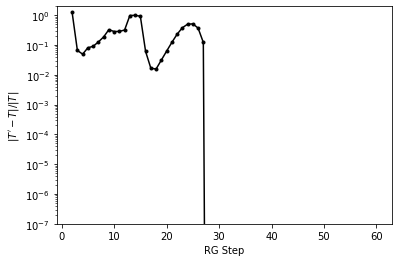

  0%|          | 0/61 [00:00<?, ?it/s]

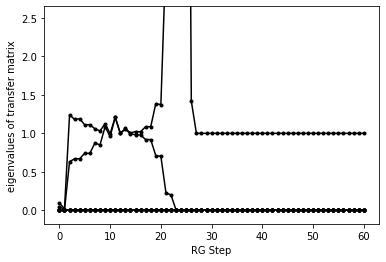

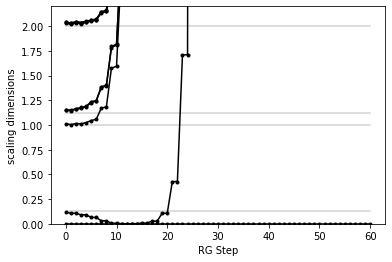

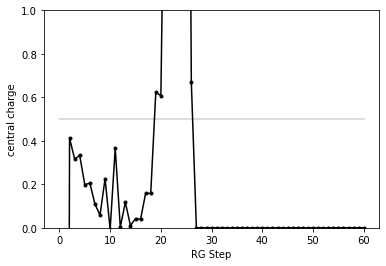

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

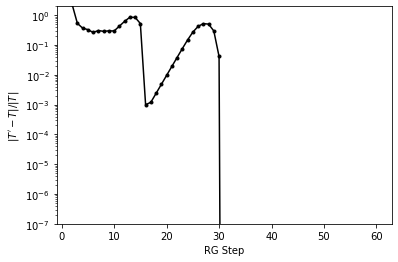

  0%|          | 0/61 [00:00<?, ?it/s]

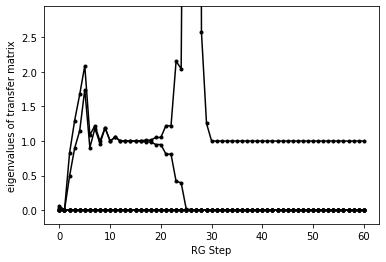

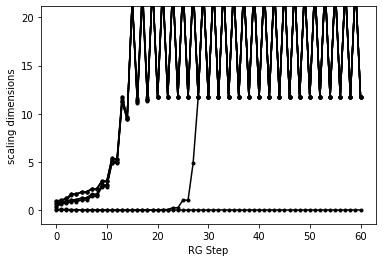

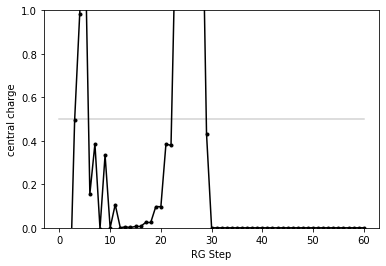

In [570]:

layers1,Ts1,logTotals1=HOTRG_layers(Tr,dimR=None,
                        max_dim=options['max_dim'],nLayers=options['nLayers'],
                        HOTRG_layer=partial(GILT_HOTRG_layer,options=gilt_options),
                        return_tensors=True)
Ts1,layers1=fix_HOTRG_gauges(Ts1,layers1)

show_diff(Ts1,stride=2)
curve=show_scaling_dimensions(Ts1,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=reference_scaling_dimensions,reference_center_charge=reference_center_charge)

layers1,Ts1,logTotals1=HOTRG_layers(Tc,dimR=None,
                        max_dim=options['max_dim'],nLayers=options['nLayers'],
                        HOTRG_layer=partial(GILT_HOTRG_layer,options=gilt_options),
                        return_tensors=True)
Ts1,layers1=fix_HOTRG_gauges(Ts1,layers1)

show_diff(Ts1,stride=2)
curve=show_scaling_dimensions(Ts1,loop_length=2,is_HOTRG=True,reference_scaling_dimensions=None,reference_center_charge=reference_center_charge)

In [385]:
T_r=torch.tensor(u[:,0]).reshape(T.shape)

In [386]:
(T_r/T_r.norm()-T/T.norm()).norm()

tensor(0.0456)

In [387]:
def get_linearized_cylinder(T):
    def evolve(v):
        v=v.reshape(T.shape)
        return contract('iIab,jJbc,kKcd,lLda,IJKL->ijkl',T,T,T,T,v).reshape(-1)
    def operator(v):
        return evolve(torch.tensor(v)).detach().cpu().numpy()
    return operator
    

In [ ]:
sref